In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import zipfile
import torchvision
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

files = zipfile.ZipFile('/content/gdrive/MyDrive/brats_slices_2.zip', 'r')
files.extractall('/content')
data_folder = Path('/content/brats_slices_2/')
df = pd.read_csv('/content/gdrive/MyDrive/meta.csv', index_col=0)

Mounted at /content/gdrive


In [ ]:
!pip install deep-pipe
from dpipe.im.metrics import dice_score

In [ ]:
from augmentations import random_crop, normalize, to_tensor
from unet16 import UNet16
from BratsDatasetClass import BraTSDataset
val_transform = transforms.Compose([
                    random_crop,
                    normalize,
                    to_tensor
            ])

subj_id = list(set(df['subject_id']))
train_size = int(len(subj_id) * 0.8)

np.random.seed(0)
train_index = np.random.choice(subj_id, train_size, replace = False)
val_index = list(set(subj_id) - set(train_index))

train_df = df[df['subject_id'].isin(train_index)]
val_df = df[df['subject_id'].isin(val_index)]

val_dataset = BraTSDataset(val_df, data_folder, transform=val_transform, nonzero_mask=True)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
model = UNet16().to(device)

## UNet with pretrained VGG-16 as encoder.

In [29]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/unet_pretrained.pt'))
model.eval()
dice = []
for i in tqdm(range(len(val_dataset))):
    x, y = val_dataset[i]
    y = y.detach().numpy().astype(bool)
    y_pred = np.exp(model(x.reshape(1,1,160,160).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
    dice.append(dice_score(y, y_pred))

print('Dice score:', np.mean(dice))


Dice score: 0.7295656054372237


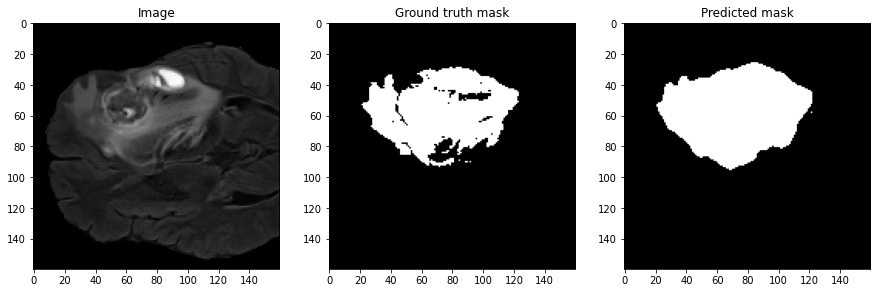

In [22]:
x, y = val_dataset[100]
y_pred = np.exp(model(x.reshape(1,1,160,160).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x[0, ...], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[0, ...], cmap='gray')
ax[1].set_title('Ground truth mask')
ax[2].imshow(y_pred[0, ...], cmap='gray')
ax[2].set_title('Predicted mask');

## UNet with pretrained VGG-16 as encoder freezed on 5 epochs.

In [23]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/unet_freezed.pt'))
model.eval()
dice = []
for i in tqdm(range(len(val_dataset))):
    x, y = val_dataset[i]
    y = y.detach().numpy().astype(bool)
    y_pred = np.exp(model(x.reshape(1,1,160,160).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
    dice.append(dice_score(y, y_pred))

print('Dice score:', np.mean(dice))


Dice score: 0.7361015411172963


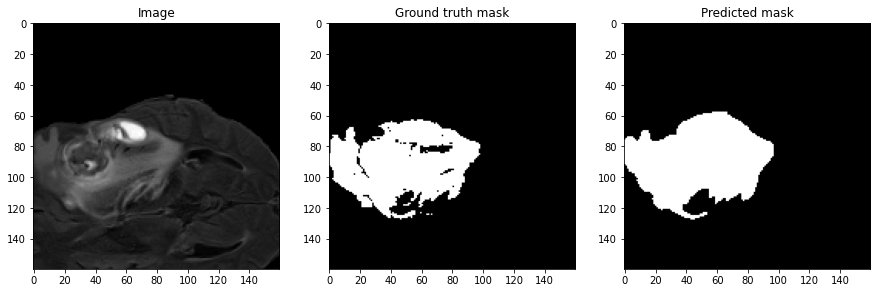

In [24]:
x, y = val_dataset[100]
y_pred = np.exp(model(x.reshape(1,1,160,160).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x[0, ...], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[0, ...], cmap='gray')
ax[1].set_title('Ground truth mask')
ax[2].imshow(y_pred[0, ...], cmap='gray')
ax[2].set_title('Predicted mask');

## UNet with VGG-16 as encoder (not pretrained).

In [27]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/unet.pt'))
model.eval()
dice = []
for i in tqdm(range(len(val_dataset))):
    x, y = val_dataset[i]
    y = y.detach().numpy().astype(bool)
    y_pred = np.exp(model(x.reshape(1,1,160,160).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
    dice.append(dice_score(y, y_pred))

print('Dice score:', np.mean(dice))


Dice score: 0.6103098651419328


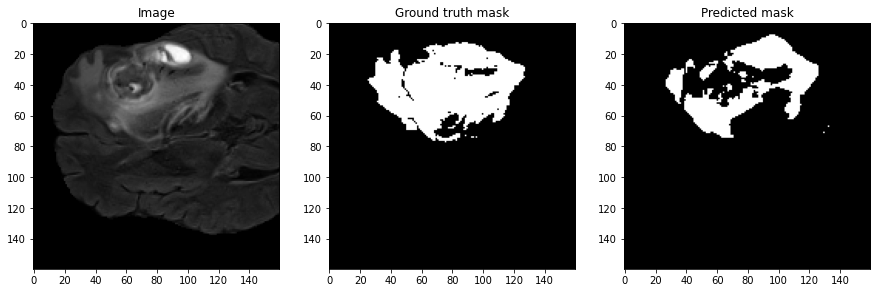

In [28]:
x, y = val_dataset[100]
y_pred = np.exp(model(x.reshape(1,1,160,160).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x[0, ...], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[0, ...], cmap='gray')
ax[1].set_title('Ground truth mask')
ax[2].imshow(y_pred[0, ...], cmap='gray')
ax[2].set_title('Predicted mask');